### Notebook for the label transfer of Healthy Human Reference to mouse ACM heart (merged Pkp2+Ttn dataset) using `scANVI`

#### Environment: scANVI

- **Developed by:** Carlos Talavera-López Ph.D
- **Modified by:** Alexandra Cirnu
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- **Date of creation:** 230918
- **Date of modification:** 240502

#### Transfer the **myeloids** from Healthy Human cell atlas to **myeloids** of ACM Ctr noninf mice (Pkp2 + Ttn)

### Import required modules

In [173]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker
import muon as mu
from muon import atac as ac
from muon import prot as pt
from scipy.sparse import csr_matrix

### Set up working environment

In [174]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                 10.2.0
absl                NA
array_api_compat    1.4.1
asttokens           NA
attr                23.2.0
chex                0.1.85
colorama            0.4.6
comm                0.2.1
contextlib2         NA
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0
debugpy             1.8.1
decorator           5.1.1
docrep              0.3.2
etils               1.7.0
exceptiongroup      1.2.0
executing           2.0.1
flax                0.8.1
fsspec              2024.2.0
h5py                3.10.0
igraph              0.11.4
importlib_resources NA
ipykernel           6.29.3
ipywidgets          8.1.2
jax                 0.4.25
jaxlib              0.4.25
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
lightning           2.1.4
lightning_utilities 0.10.1
llvmlite            0.42.0
matplotlib          3.8.3
matplotlib_inline   0.1.6
mizani              0.11.0
ml_colle

In [175]:
def X_is_raw(adata): return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

In [176]:
torch.set_float32_matmul_precision('high')

In [177]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Seed set to 1712


In [178]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

### Read in Healthy data

In [179]:
# Data set with lineage information from Healthy human heart leucocytes (from Human cell atlas) 

reference = sc.read_h5ad('/home/acirnu/github/ACM_Mouse_Immune/Workflow/4_Seed_labeling_with_scANVI/A_Transfer_LINEAGE_seeds_from_HCAref_to_data/HCA_myeloids_healthy_reference_ac240319.raw.h5ad')
reference

AnnData object with n_obs × n_vars = 23842 × 33538
    obs: 'NRP', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'region', 'sample', 'scNym', 'scNym_confidence', 'lineage'
    uns: 'cell_states_colors', 'scNym_colors', 'scNym_probabilities'
    obsm: 'X_pca', 'X_scnym', 'X_umap'
    layers: 'counts'

In [180]:
X_is_raw(reference)

True

In [181]:
reference.obs

,NRP,cell_source,cell_states,donor,gender,n_counts,n_genes,region,sample,scNym,scNym_confidence,lineage
AACAACCGTAATTGGA-1-H0015_apex,No,Harvard-Nuclei,DOCK4+MØ1,H5,Female,730.082947,578,AX,H0015_apex,CD14+Monocyte,0.538159,myeloid
AAGACTCTCAGGACGA-1-H0015_apex,No,Harvard-Nuclei,Mast,H5,Female,612.323425,428,AX,H0015_apex,Mast,0.990977,myeloid
AAGCATCGTTCGCGTG-1-H0015_apex,No,Harvard-Nuclei,LYVE1+MØ2,H5,Female,887.090454,1124,AX,H0015_apex,MØ,0.816231,myeloid
AAGCCATCAGCACAGA-1-H0015_apex,No,Harvard-Nuclei,LYVE1+MØ3,H5,Female,905.353455,1301,AX,H0015_apex,MØ,0.994292,myeloid
AAGCGAGTCAAGGTGG-1-H0015_apex,No,Harvard-Nuclei,Mast,H5,Female,605.308716,401,AX,H0015_apex,Mast,0.887313,myeloid
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCCACCACTGG-1-HCAHeart8102862,Yes,Sanger-CD45,LYVE1+MØ1,D11,Female,869.875061,2411,AX,HCAHeart8102862,MØ,0.986432,myeloid
TTTGATCGTTCTCCTG-1-HCAHeart8102862,Yes,Sanger-CD45,LYVE1+MØ1,D11,Female,819.040100,2526,AX,HCAHeart8102862,CD8+T_cell,0.269561,myeloid
TTTGGAGGTCGCTCGA-1-HCAHeart8102862,Yes,Sanger-CD45,MØ_AgP,D11,Female,757.455505,1350,AX,HCAHeart8102862,M3,0.585436,myeloid
TTTGGTTTCAGTGTTG-1-HCAHeart8102862,Yes,Sanger-CD45,LYVE1+MØ3,D11,Female,815.372131,2507,AX,HCAHeart8102862,MØ,0.968681,myeloid


In [182]:
reference.obs["general_cell_types"] = reference.obs['cell_states'].copy()

In [183]:
trans_from = [  
              ['CD16+Mo', 'CD14+Mo','Mo_pi', 'IL17RA+Mo'],              #Monocytes
              ['DOCK4+MØ1', 'DOCK4+MØ2'],                               #DOCK4+ Macrophages
              ['LYVE1+MØ1', 'LYVE1+MØ2', 'LYVE1+MØ3',],                 #LYVE1+ Macrophages
              ['MØ_mod', 'MØ_AgP'],                                     #Macrophages_general
              ['Mast'],                                                 #Mast_cells
              ['DC'],                                                   #DC
              ['NØ']                                                   #Neutrophils
]

trans_to = ['Monocytes', 'DOCK4+MØ', 'LYVE1+MØ', 'MØ_general', 'Mast', 'DC','Neutrophils']

reference.obs['general_cell_types'] = [str(i) for i in reference.obs['cell_states']]
for leiden,celltype in zip(trans_from, trans_to):
    for leiden_from in leiden:
        reference.obs['general_cell_types'][reference.obs['general_cell_types'] == leiden_from] = celltype

In [184]:
reference.obs

,NRP,cell_source,cell_states,donor,gender,n_counts,n_genes,region,sample,scNym,scNym_confidence,lineage,general_cell_types
AACAACCGTAATTGGA-1-H0015_apex,No,Harvard-Nuclei,DOCK4+MØ1,H5,Female,730.082947,578,AX,H0015_apex,CD14+Monocyte,0.538159,myeloid,DOCK4+MØ
AAGACTCTCAGGACGA-1-H0015_apex,No,Harvard-Nuclei,Mast,H5,Female,612.323425,428,AX,H0015_apex,Mast,0.990977,myeloid,Mast
AAGCATCGTTCGCGTG-1-H0015_apex,No,Harvard-Nuclei,LYVE1+MØ2,H5,Female,887.090454,1124,AX,H0015_apex,MØ,0.816231,myeloid,LYVE1+MØ
AAGCCATCAGCACAGA-1-H0015_apex,No,Harvard-Nuclei,LYVE1+MØ3,H5,Female,905.353455,1301,AX,H0015_apex,MØ,0.994292,myeloid,LYVE1+MØ
AAGCGAGTCAAGGTGG-1-H0015_apex,No,Harvard-Nuclei,Mast,H5,Female,605.308716,401,AX,H0015_apex,Mast,0.887313,myeloid,Mast
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCCACCACTGG-1-HCAHeart8102862,Yes,Sanger-CD45,LYVE1+MØ1,D11,Female,869.875061,2411,AX,HCAHeart8102862,MØ,0.986432,myeloid,LYVE1+MØ
TTTGATCGTTCTCCTG-1-HCAHeart8102862,Yes,Sanger-CD45,LYVE1+MØ1,D11,Female,819.040100,2526,AX,HCAHeart8102862,CD8+T_cell,0.269561,myeloid,LYVE1+MØ
TTTGGAGGTCGCTCGA-1-HCAHeart8102862,Yes,Sanger-CD45,MØ_AgP,D11,Female,757.455505,1350,AX,HCAHeart8102862,M3,0.585436,myeloid,MØ_general
TTTGGTTTCAGTGTTG-1-HCAHeart8102862,Yes,Sanger-CD45,LYVE1+MØ3,D11,Female,815.372131,2507,AX,HCAHeart8102862,MØ,0.968681,myeloid,LYVE1+MØ


In [185]:
reference.obs['seed_labels'] = reference.obs['general_cell_types'].copy()

In [186]:
reference.obs['seed_labels'].value_counts() 

seed_labels
LYVE1+MØ       7063
Monocytes      6845
DOCK4+MØ       4865
MØ_general     2591
Mast           1543
DC              814
Neutrophils     121
Name: count, dtype: int64

### Subset populations of interest

In [187]:
reference = reference[~reference.obs['seed_labels'].isin(['nan'])]              # = filter out not assigned cells, keep everything that is not 'nan'
reference.obs['seed_labels'].value_counts()

seed_labels
LYVE1+MØ       7063
Monocytes      6845
DOCK4+MØ       4865
MØ_general     2591
Mast           1543
DC              814
Neutrophils     121
Name: count, dtype: int64

In [188]:
sc.pp.filter_cells(reference, min_genes = 200)            
sc.pp.filter_cells(reference, min_counts = 100)

### Read in query

In [189]:
mdata = mu.read_h5mu('/home/acirnu/github/ACM_Mouse_Immune/Workflow/4_Seed_labeling_with_scANVI/A_Transfer_LINEAGE_seeds_from_HCAref_to_data/ACM_scANVI_extracted_myeloids_from_HCA_muon_ac240409.raw.h5mu')
mdata

MuData object with n_obs × n_vars = 34490 × 29477
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	34490 x 29378
      obs:	'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
      var:	'gene_ids', 'feature_types', 'mt', 'ribo'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap'
    prot:	34490 x 99
      obs:	'library', 'batch'
      var:	'gene_ids', 'feature_types'
      uns:	'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log_norm'

In [190]:
#Merged Pkp2+Ttn Libraries subsetted to contain only control mice (Pkp_Ctr_noninf and Ttn_Ctr_noninf)
query = mdata.mod['rna']
query.obs['cell_source'] = 'AG_Gerull'
query.obs['seed_labels'] = 'Unknown'
query.obs['donor'] = query.obs['sample'].copy()
query

AnnData object with n_obs × n_vars = 34490 × 29378
    obs: 'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [191]:
query.obs

,cell_source,donor,n_counts,sample,seed_labels,condition,genotype,infection,library,model,...,pct_counts_ribo,percent_mt,percent_chrY,XIST-counts,S_score,G2M_score,batch,_scvi_batch,_scvi_labels,C_scANVI
AAACGCTGTTGTGTTG-1-A1,AG_Gerull,Pkp2_Ctr_noninf_1,750.0,Pkp2_Ctr_noninf_1,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,4.533333,0.346667,0.000000,0.0,-0.019995,-0.083225,reference,6,0,myeloid
AAACGCTTCTCGCTCA-1-A1,AG_Gerull,Pkp2_Ctr_noninf_1,3855.0,Pkp2_Ctr_noninf_1,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,1.815824,0.043320,0.025940,0.0,-0.169221,-0.390143,reference,6,0,myeloid
AAAGGTACAGAACATA-1-A1,AG_Gerull,Pkp2_Ctr_noninf_2,17536.0,Pkp2_Ctr_noninf_2,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,10.213275,0.027315,0.051323,0.0,-0.317631,-0.578955,reference,7,0,myeloid
AAAGTCCAGGGACACT-1-A1,AG_Gerull,Pkp2_Ctr_noninf_2,14174.0,Pkp2_Ctr_noninf_2,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,14.456045,0.023282,0.014110,0.0,-0.370103,-0.370084,reference,7,0,myeloid
AAAGTCCCAGTAGGAC-1-A1,AG_Gerull,Pkp2_Ctr_noninf_2,12498.0,Pkp2_Ctr_noninf_2,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,9.809569,0.016323,0.040006,0.0,-0.142503,-0.357287,reference,7,0,myeloid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGAGGTTAGTA-1-B2,AG_Gerull,Ttn_HetKO_MCMV_1,4226.0,Ttn_HetKO_MCMV_1,Unknown,Ttn_HetKO_MCMV,Ttn_HetKO,MCMV,B2,Ttn,...,4.448651,0.000710,0.141978,0.0,-0.373712,-0.402608,query,25,2,myeloid
TTTGTTGCAAGCTCTA-1-B2,AG_Gerull,Ttn_Ctr_noninf_1,3733.0,Ttn_Ctr_noninf_1,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,Ttn,...,5.062952,0.017412,0.000000,0.0,-0.179842,-0.495021,query,23,2,myeloid
TTTGTTGGTACAGGTG-1-B2,AG_Gerull,Ttn_Ctr_MCMV_2,24293.0,Ttn_Ctr_MCMV_2,Unknown,Ttn_Ctr_MCMV,Ttn_Ctr,MCMV,B2,Ttn,...,13.086075,0.037254,0.000000,13.0,-0.435458,-0.744327,query,21,2,myeloid
TTTGTTGTCCCAGGAC-1-B2,AG_Gerull,Ttn_Ctr_noninf_2,6388.0,Ttn_Ctr_noninf_2,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,Ttn,...,7.247965,0.023168,0.140889,0.0,0.080642,-0.877899,query,24,2,myeloid


In [192]:
X_is_raw(query)

True

In [193]:
query = query[query.obs['condition'].isin(["Pkp2_Ctr_noninf", "Ttn_Ctr_noninf"]) , :]
del(query.obs['batch'])
query.obs

,cell_source,donor,n_counts,sample,seed_labels,condition,genotype,infection,library,model,...,total_counts_ribo,pct_counts_ribo,percent_mt,percent_chrY,XIST-counts,S_score,G2M_score,_scvi_batch,_scvi_labels,C_scANVI
AAACGCTGTTGTGTTG-1-A1,AG_Gerull,Pkp2_Ctr_noninf_1,750.0,Pkp2_Ctr_noninf_1,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,34.0,4.533333,0.346667,0.000000,0.0,-0.019995,-0.083225,6,0,myeloid
AAACGCTTCTCGCTCA-1-A1,AG_Gerull,Pkp2_Ctr_noninf_1,3855.0,Pkp2_Ctr_noninf_1,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,70.0,1.815824,0.043320,0.025940,0.0,-0.169221,-0.390143,6,0,myeloid
AAAGGTACAGAACATA-1-A1,AG_Gerull,Pkp2_Ctr_noninf_2,17536.0,Pkp2_Ctr_noninf_2,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,1791.0,10.213275,0.027315,0.051323,0.0,-0.317631,-0.578955,7,0,myeloid
AAAGTCCAGGGACACT-1-A1,AG_Gerull,Pkp2_Ctr_noninf_2,14174.0,Pkp2_Ctr_noninf_2,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,2049.0,14.456045,0.023282,0.014110,0.0,-0.370103,-0.370084,7,0,myeloid
AAAGTCCCAGTAGGAC-1-A1,AG_Gerull,Pkp2_Ctr_noninf_2,12498.0,Pkp2_Ctr_noninf_2,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,1226.0,9.809569,0.016323,0.040006,0.0,-0.142503,-0.357287,7,0,myeloid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCACGCAGTC-1-B2,AG_Gerull,Ttn_Ctr_noninf_2,18844.0,Ttn_Ctr_noninf_2,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,Ttn,...,2868.0,15.219699,0.036245,0.000000,0.0,-0.901389,-1.291862,24,2,myeloid
TTTGGTTTCCTGTACC-1-B2,AG_Gerull,Ttn_Ctr_noninf_2,11805.0,Ttn_Ctr_noninf_2,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,Ttn,...,1469.0,12.443880,0.022279,0.025413,1.0,-0.277671,-0.184796,24,2,myeloid
TTTGTTGCAAGCTCTA-1-B2,AG_Gerull,Ttn_Ctr_noninf_1,3733.0,Ttn_Ctr_noninf_1,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,Ttn,...,189.0,5.062952,0.017412,0.000000,0.0,-0.179842,-0.495021,23,2,myeloid
TTTGTTGTCCCAGGAC-1-B2,AG_Gerull,Ttn_Ctr_noninf_2,6388.0,Ttn_Ctr_noninf_2,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,Ttn,...,463.0,7.247965,0.023168,0.140889,0.0,0.080642,-0.877899,24,2,myeloid


In [194]:
sc.pp.filter_cells(query, min_genes = 200)
sc.pp.filter_cells(query, min_counts = 100)

filtered out 11 cells that have less than 200 genes expressed


### Change gene symbols for label transfer

In [195]:
query.var_names = [gene_name.upper() for gene_name in query.var_names]                      #capitalize gene names to match with the human genes from reference
query.var_names

Index(['XKR4', 'GM1992', 'GM19938', 'GM37381', 'RP1', 'SOX17', 'GM37587',
       'GM37323', 'MRPL15', 'LYPLA1',
       ...
       'VMN2R122', 'IL11RA2-1', 'CCL27A-1', 'CCL21C-1', 'CCL27A-2',
       'IL11RA2-2', 'CCL19-1', 'CCL21A-1', 'GM10931', 'GM16367'],
      dtype='object', length=29378)

### Merge reference and query (make sure the seed_labels of query are 'Unknown')

In [196]:
adata = reference.concatenate(query, batch_key = 'batch', batch_categories = ['reference', 'query'], join = 'inner')                #merge to one adata object
adata

AnnData object with n_obs × n_vars = 30550 × 16194
    obs: 'NRP', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'region', 'sample', 'scNym', 'scNym_confidence', 'lineage', 'general_cell_types', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'batch'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query'
    obsm: 'X_umap'

In [197]:
adata.obs['seed_labels'] = adata.obs['seed_labels'].astype('category')
adata.obs['seed_labels'].cat.categories

Index(['DC', 'DOCK4+MØ', 'LYVE1+MØ', 'Mast', 'Monocytes', 'MØ_general',
       'Neutrophils', 'Unknown'],
      dtype='object')

In [198]:
adata.obs['batch'].value_counts()

batch
reference    23842
query         6708
Name: count, dtype: int64

### Select HVGs

In [199]:
adata.obs['donor'] = adata.obs['donor'].astype('str') 
adata.obs['donor'].value_counts()

donor
D7                   4536
D6                   4495
D11                  3556
D3                   1658
Ttn_Ctr_noninf_1     1575
D2                   1543
Ttn_Ctr_noninf_2     1373
Pkp2_Ctr_noninf_2    1350
H7                   1242
H3                   1220
H2                   1082
Pkp2_Ctr_noninf_4    1071
D4                    937
D5                    897
H5                    825
Pkp2_Ctr_noninf_3     794
H6                    759
H4                    711
Pkp2_Ctr_noninf_1     545
D1                    381
Name: count, dtype: int64

In [200]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "donor",
    subset = True,
    span = 1
    )

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 30550 × 7000
    obs: 'NRP', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'region', 'sample', 'scNym', 'scNym_confidence', 'lineage', 'general_cell_types', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'batch'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    obsm: 'X_umap'
    layers: 'counts'

### Transfer of annotation with scANVI

In [201]:
scvi.model.SCVI.setup_anndata(adata, 
                              batch_key = 'donor', 
                              labels_key = 'seed_labels',
                              layer = 'counts',
                              categorical_covariate_keys = ['donor', 'cell_source'])

In [202]:
scvi_model = scvi.model.SCVI(adata, 
                             n_latent = 150, 
                             n_layers = 3, 
                             dispersion = 'gene-batch', 
                             gene_likelihood = 'nb')

In [203]:
scvi_model.train(9, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True,
                 accelerator = "gpu",
                 devices = [1]                                        
                 )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 9/9: 100%|██████████| 9/9 [00:12<00:00,  1.33s/it, v_num=1, train_loss_step=2.56e+3, train_loss_epoch=2.42e+3]

`Trainer.fit` stopped: `max_epochs=9` reached.


Epoch 9/9: 100%|██████████| 9/9 [00:12<00:00,  1.35s/it, v_num=1, train_loss_step=2.56e+3, train_loss_epoch=2.42e+3]


### Evaluate model performance a la _Sevensson_

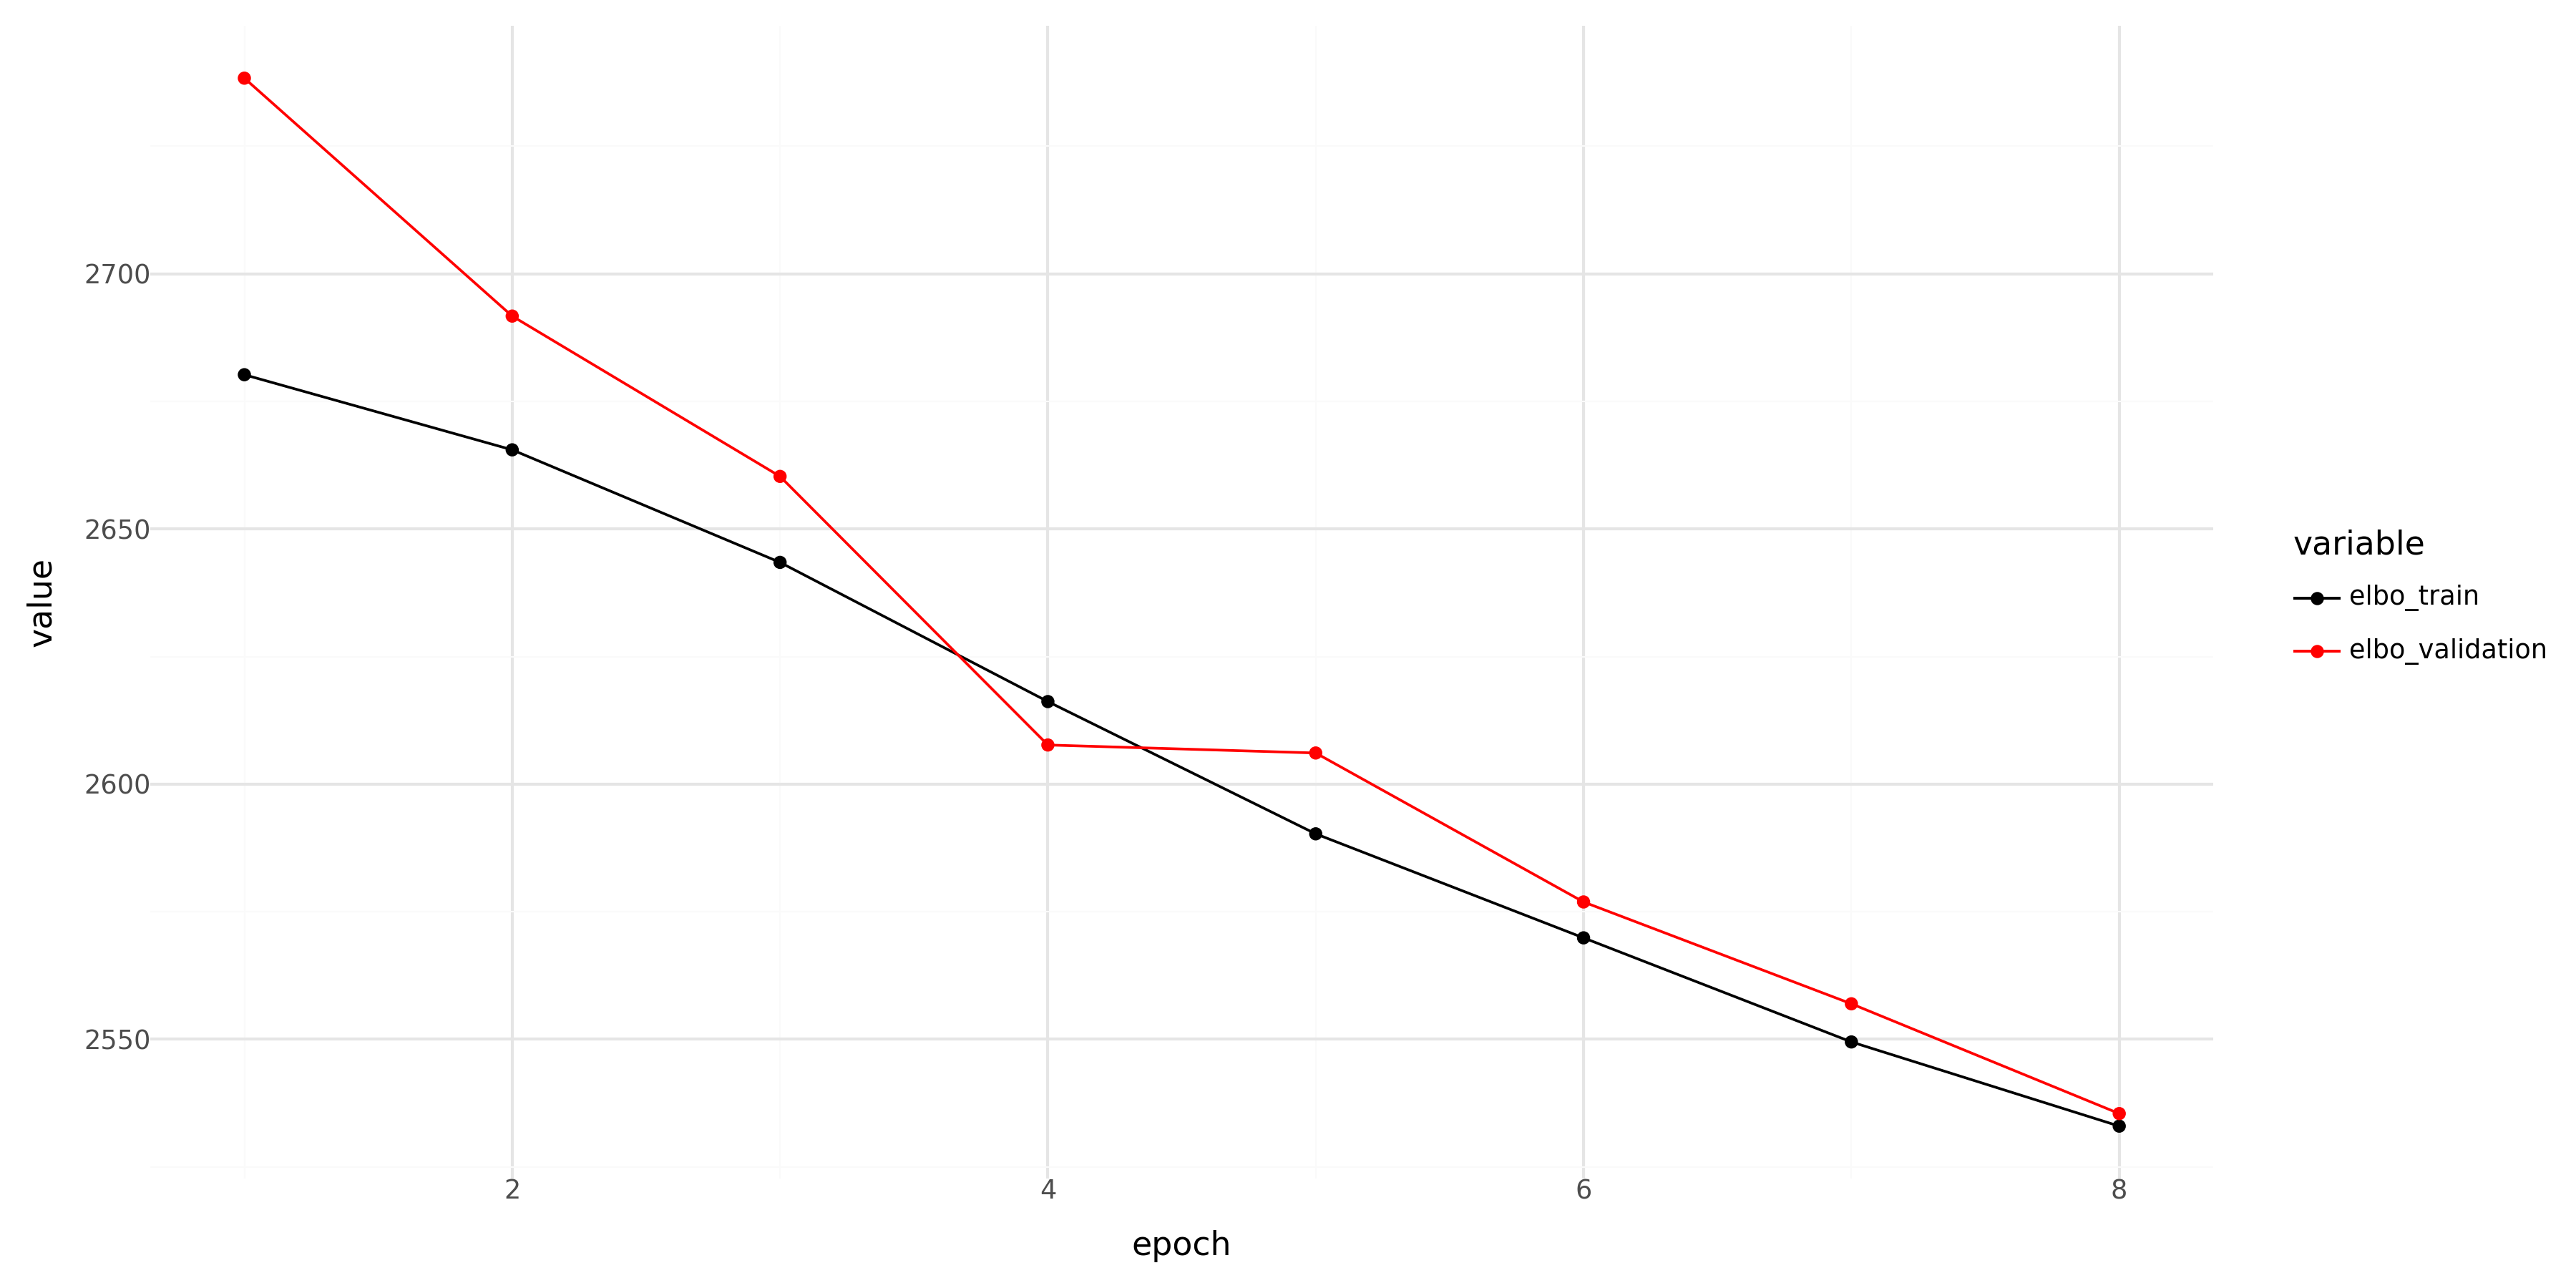

In [204]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

- get latent representation

In [205]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation()

### Label transfer with `scANVI` 

In [206]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [207]:
scanvi_model.train(6, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True,
                   accelerator = "gpu",
                   devices = [1]                            
)

INFO     Training for 6 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 6/6: 100%|██████████| 6/6 [00:23<00:00,  3.96s/it, v_num=1, train_loss_step=2.28e+3, train_loss_epoch=2.39e+3]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 6/6: 100%|██████████| 6/6 [00:23<00:00,  3.93s/it, v_num=1, train_loss_step=2.28e+3, train_loss_epoch=2.39e+3]


### Evaluate model performance a la Svensson

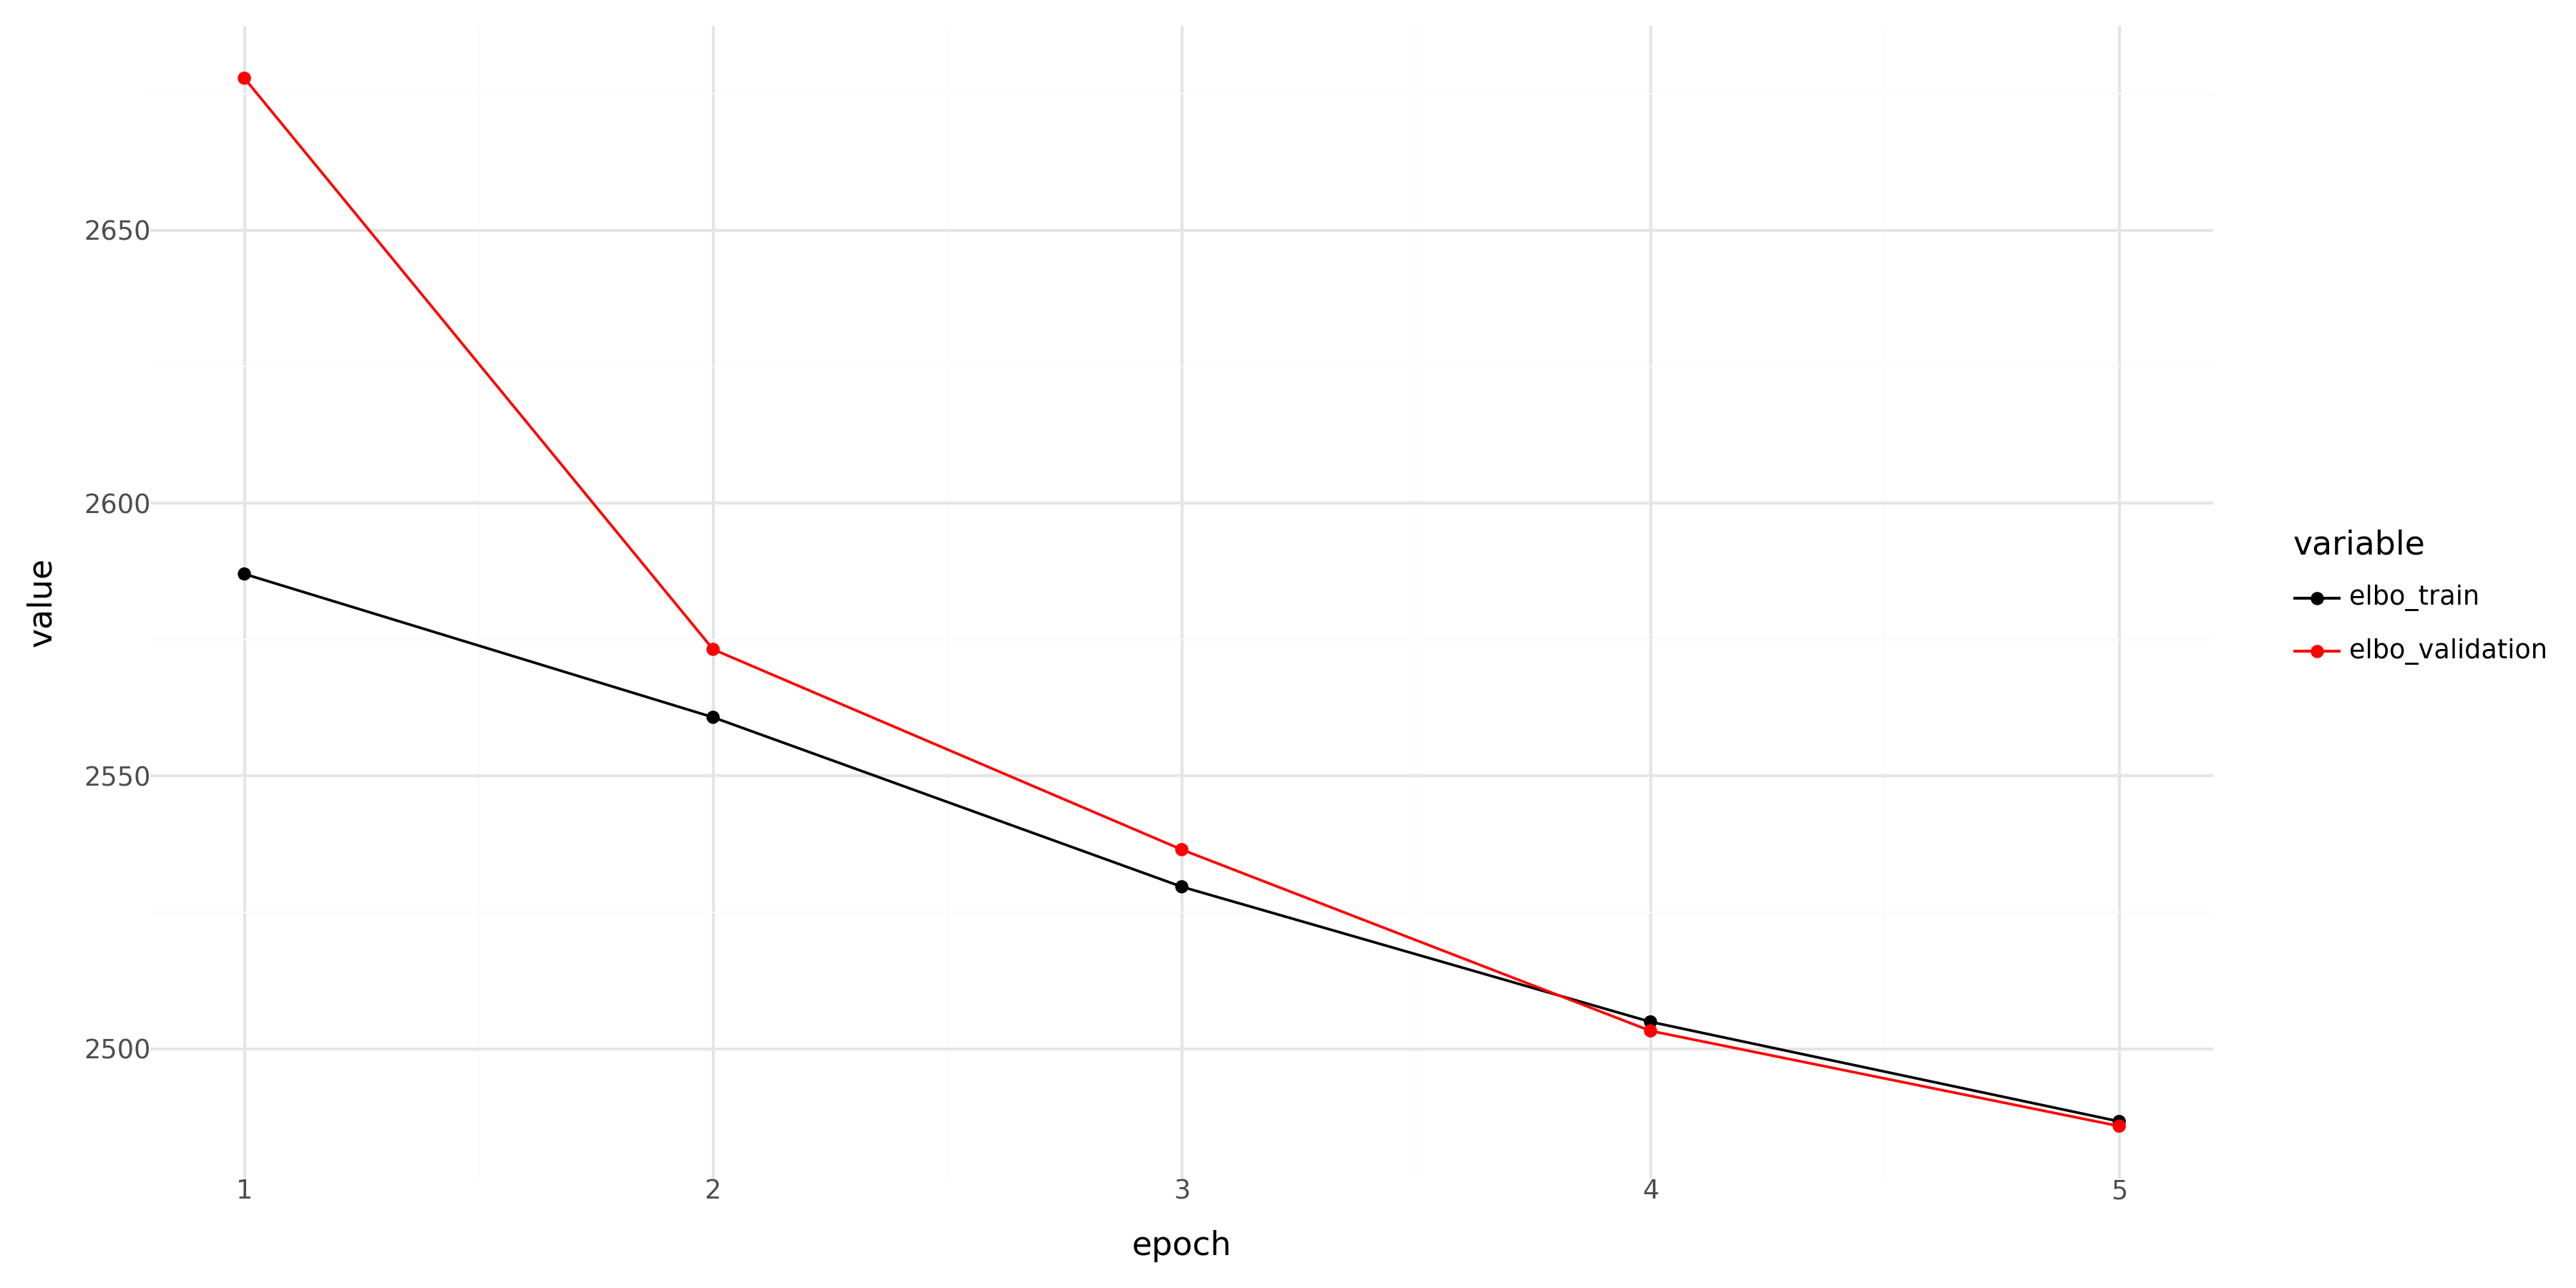

In [208]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig2.png', dpi = 300)

print(p_)

In [209]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [210]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

In [211]:
adata.obs

,NRP,cell_source,cell_states,donor,gender,n_counts,n_genes,region,sample,scNym,...,pct_counts_ribo,percent_mt,percent_chrY,XIST-counts,S_score,G2M_score,_scvi_batch,_scvi_labels,C_scANVI,batch
AACAACCGTAATTGGA-1-H0015_apex-reference,No,Harvard-Nuclei,DOCK4+MØ1,H5,Female,709.0,578,AX,H0015_apex,CD14+Monocyte,...,NaN,NaN,NaN,NaN,NaN,NaN,11,1,DOCK4+MØ,reference
AAGACTCTCAGGACGA-1-H0015_apex-reference,No,Harvard-Nuclei,Mast,H5,Female,545.0,428,AX,H0015_apex,Mast,...,NaN,NaN,NaN,NaN,NaN,NaN,11,3,Mast,reference
AAGCATCGTTCGCGTG-1-H0015_apex-reference,No,Harvard-Nuclei,LYVE1+MØ2,H5,Female,1637.0,1124,AX,H0015_apex,MØ,...,NaN,NaN,NaN,NaN,NaN,NaN,11,2,LYVE1+MØ,reference
AAGCCATCAGCACAGA-1-H0015_apex-reference,No,Harvard-Nuclei,LYVE1+MØ3,H5,Female,1941.0,1301,AX,H0015_apex,MØ,...,NaN,NaN,NaN,NaN,NaN,NaN,11,2,LYVE1+MØ,reference
AAGCGAGTCAAGGTGG-1-H0015_apex-reference,No,Harvard-Nuclei,Mast,H5,Female,503.0,401,AX,H0015_apex,Mast,...,NaN,NaN,NaN,NaN,NaN,NaN,11,3,Mast,reference
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCACGCAGTC-1-B2-query,NaN,AG_Gerull,NaN,Ttn_Ctr_noninf_2,NaN,17937.0,4112,NaN,Ttn_Ctr_noninf_2,NaN,...,15.219699,0.036245,0.000000,0.0,-0.901389,-1.291862,19,7,MØ_general,query
TTTGGTTTCCTGTACC-1-B2-query,NaN,AG_Gerull,NaN,Ttn_Ctr_noninf_2,NaN,11437.0,3253,NaN,Ttn_Ctr_noninf_2,NaN,...,12.443880,0.022279,0.025413,1.0,-0.277671,-0.184796,19,7,MØ_general,query
TTTGTTGCAAGCTCTA-1-B2-query,NaN,AG_Gerull,NaN,Ttn_Ctr_noninf_1,NaN,3535.0,1791,NaN,Ttn_Ctr_noninf_1,NaN,...,5.062952,0.017412,0.000000,0.0,-0.179842,-0.495021,18,7,DOCK4+MØ,query
TTTGTTGTCCCAGGAC-1-B2-query,NaN,AG_Gerull,NaN,Ttn_Ctr_noninf_2,NaN,6168.0,2505,NaN,Ttn_Ctr_noninf_2,NaN,...,7.247965,0.023168,0.140889,0.0,0.080642,-0.877899,19,7,MØ_general,query


- Visualise corrected dataset

In [212]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 150, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 1, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:29)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:20)


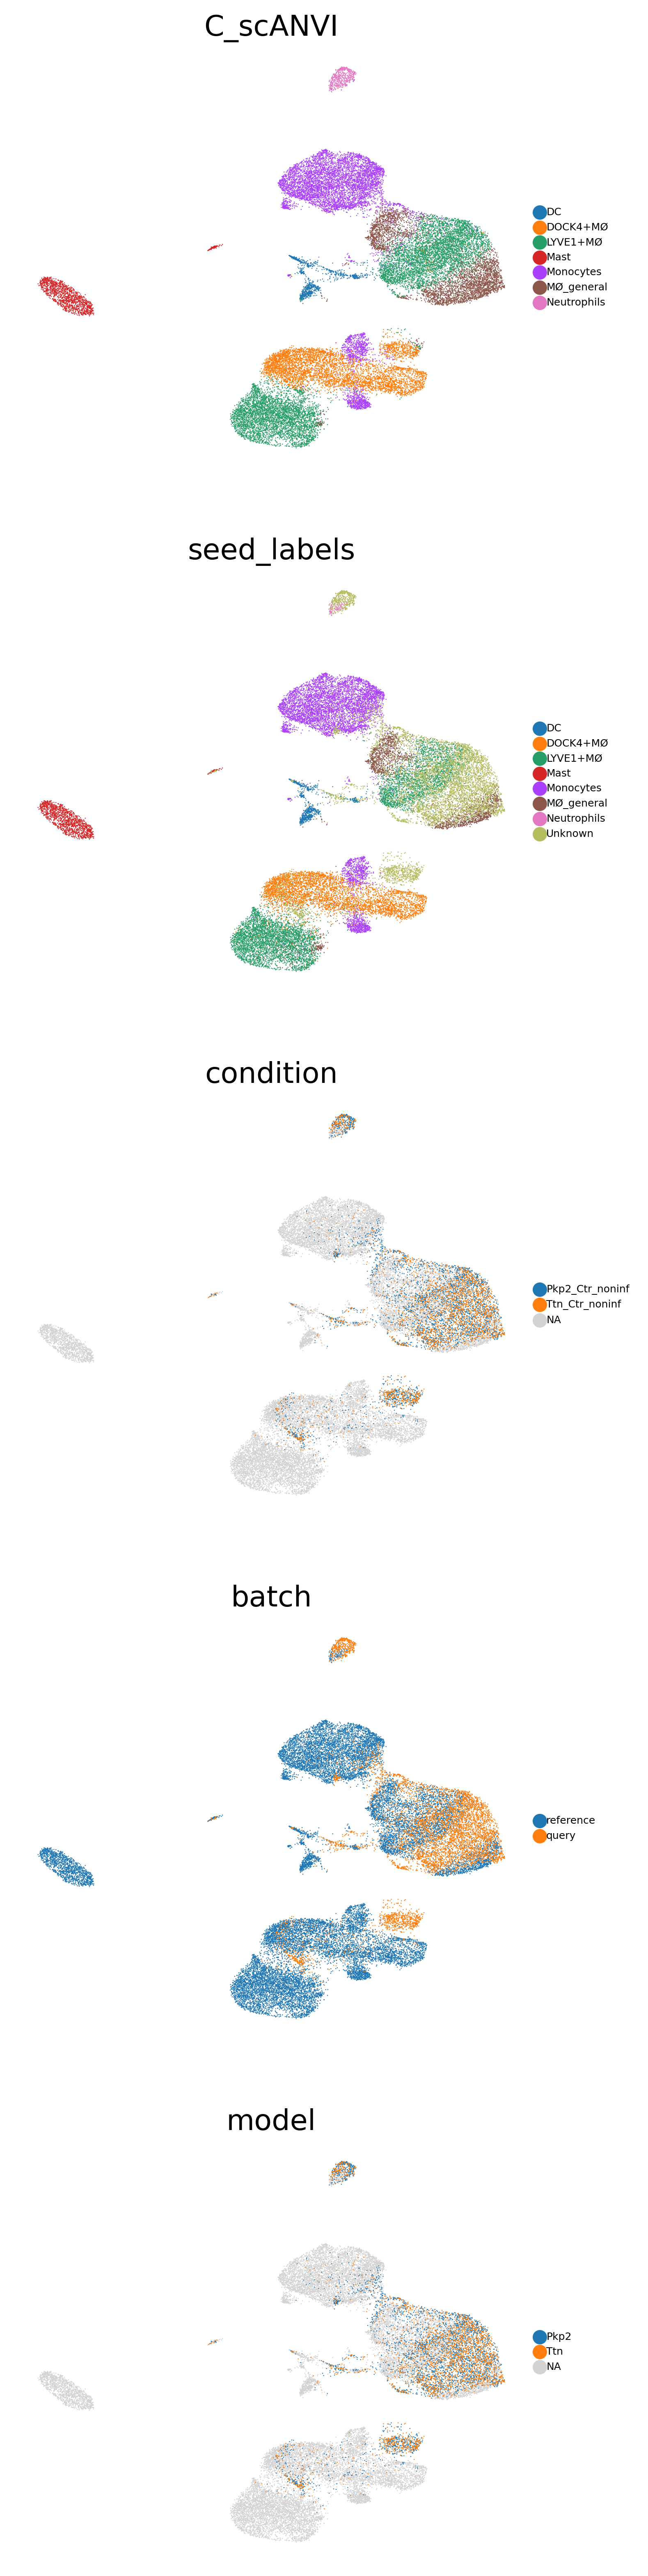

In [213]:
sc.pl.umap(adata, frameon = False, color = ['C_scANVI', 'seed_labels', 'condition', 'batch', 'model'], size = 1, legend_fontsize = 5, ncols = 1)

### Compute `scib-metrics`

In [214]:
adata

AnnData object with n_obs × n_vars = 30550 × 7000
    obs: 'NRP', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'region', 'sample', 'scNym', 'scNym_confidence', 'lineage', 'general_cell_types', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'batch'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'C_scANVI_colors', 'seed_labels_colors', 'condition_colors', 'batch_colors', 'model_colors'
    obsm: 'X_umap', '_scvi_extra_categorical_covs', 'X_scVI', 'X_scANVI'
    layers: 'counts'
    obsp: '

In [215]:
bm = Benchmarker(
    adata,
    batch_key="donor",
    label_key="seed_labels",                                       
    embedding_obsm_keys=["X_scVI", "X_scANVI", "X_pca"],
    n_jobs=-1,
)
bm.benchmark()

computing PCA
    with n_comps=50
    finished (0:00:06)


Embeddings: 100%|██████████| 3/3 [07:34<00:00, 151.63s/it]


In [216]:
print(adata.X.dtype)

float32


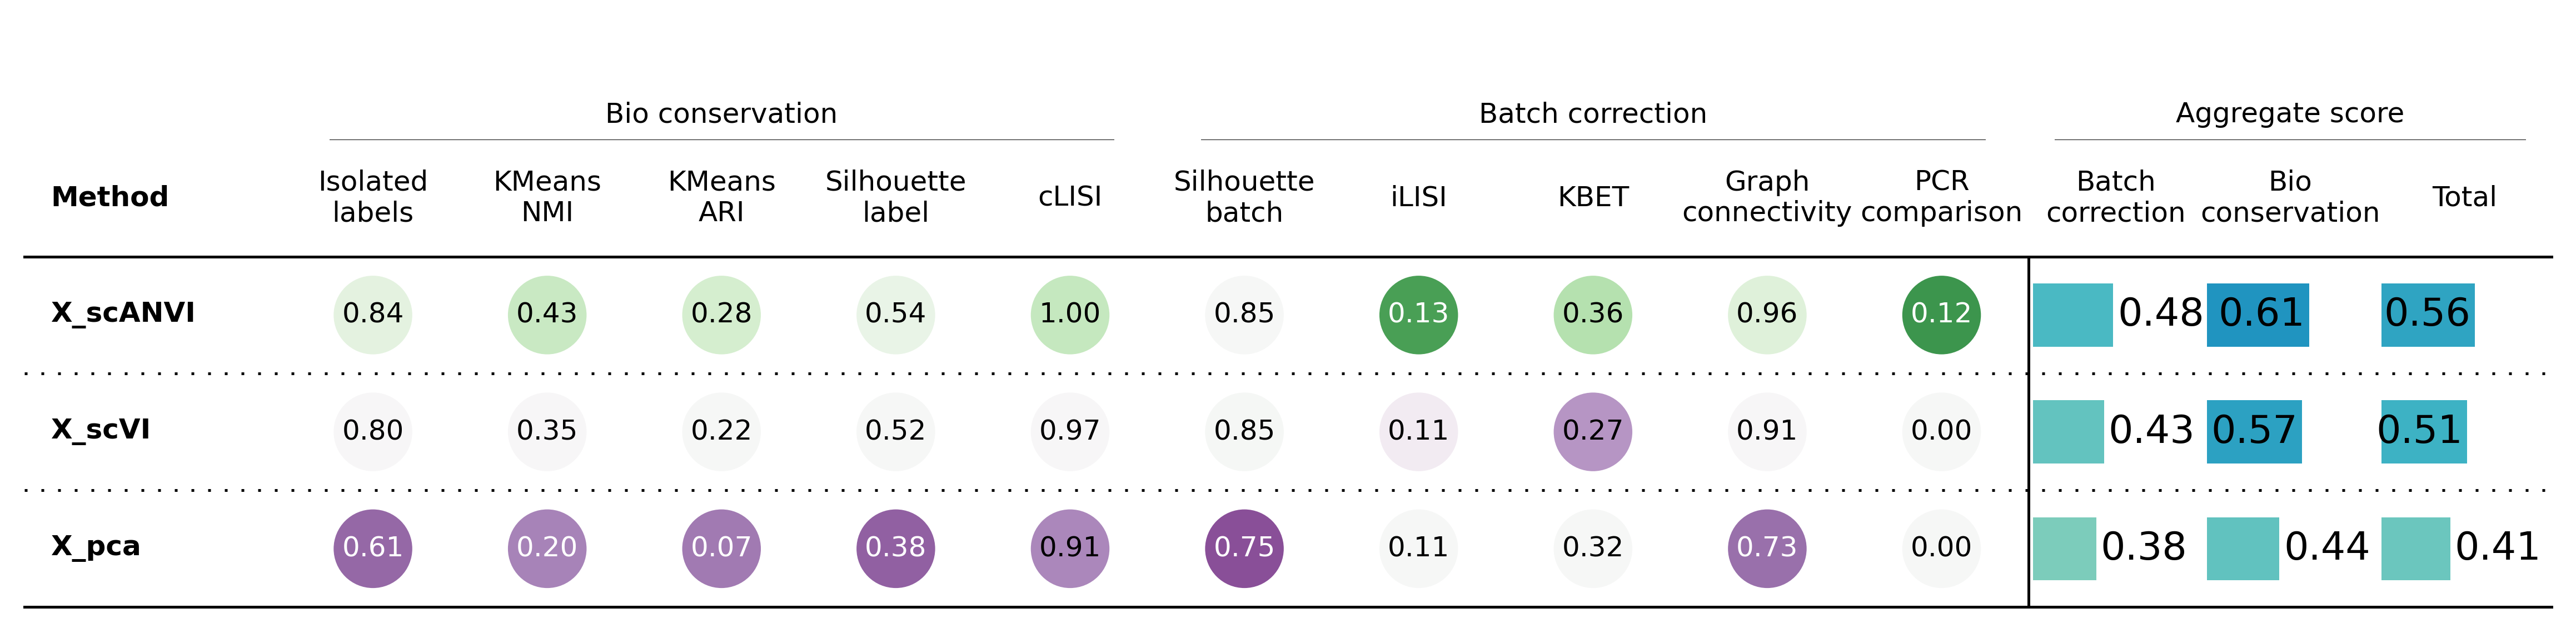

In [217]:
bm.plot_results_table(min_max_scale=False)

In [218]:
df = bm.get_results(min_max_scale=False)
df.transpose()

Embedding,X_scVI,X_scANVI,X_pca,Metric Type
Isolated labels,0.797369,0.836637,0.609828,Bio conservation
KMeans NMI,0.351272,0.425829,0.201074,Bio conservation
KMeans ARI,0.217995,0.276313,0.069343,Bio conservation
Silhouette label,0.519629,0.538169,0.383212,Bio conservation
cLISI,0.966865,0.995469,0.914324,Bio conservation
Silhouette batch,0.851763,0.850446,0.752427,Batch correction
iLISI,0.1095,0.130031,0.111435,Batch correction
KBET,0.274847,0.355537,0.320968,Batch correction
Graph connectivity,0.914279,0.964968,0.725541,Batch correction
PCR comparison,0,0.120012,0.0,Batch correction


### Export annotated object

In [219]:
adata_export_merged = anndata.AnnData(X = adata_raw.X, var = adata_raw.var, obs = adata.obs)            #export a merged AnnData object with raw values from X and raw genes but modified observations
adata_export_merged

AnnData object with n_obs × n_vars = 30550 × 16194
    obs: 'NRP', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'region', 'sample', 'scNym', 'scNym_confidence', 'lineage', 'general_cell_types', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'batch'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query'

In [220]:
adata_export = adata_export_merged[adata_export_merged.obs['batch'].isin(['query'])]                    #subset merged data set to keep only query
adata_export

View of AnnData object with n_obs × n_vars = 6708 × 16194
    obs: 'NRP', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'region', 'sample', 'scNym', 'scNym_confidence', 'lineage', 'general_cell_types', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'batch'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query'

### Add new gene symbols

In [221]:
query_export = anndata.AnnData(X = query.X, var = query.var, obs = adata_export.obs)                    #make sure to store the raw X values and the raw genes together with modified observations
query_export

AnnData object with n_obs × n_vars = 6708 × 29378
    obs: 'NRP', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'region', 'sample', 'scNym', 'scNym_confidence', 'lineage', 'general_cell_types', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'batch'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo'

### Revert gene symbols

In [222]:
query_export.var_names = [gene_name.capitalize() for gene_name in query_export.var_names]           #restore mouse nomenclature
query_export.var_names

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1',
       ...
       'Vmn2r122', 'Il11ra2-1', 'Ccl27a-1', 'Ccl21c-1', 'Ccl27a-2',
       'Il11ra2-2', 'Ccl19-1', 'Ccl21a-1', 'Gm10931', 'Gm16367'],
      dtype='object', length=29378)

In [223]:
query_export.obs['C_scANVI'].value_counts()

C_scANVI
LYVE1+MØ       2754
MØ_general     1954
DOCK4+MØ        893
Monocytes       503
Neutrophils     418
DC              165
Mast             21
Name: count, dtype: int64

In [224]:
query_export

AnnData object with n_obs × n_vars = 6708 × 29378
    obs: 'NRP', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'region', 'sample', 'scNym', 'scNym_confidence', 'lineage', 'general_cell_types', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'batch'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo'

In [225]:
#Clean up metadata - delete all columns that came from merging with reference data set

del(query_export.obs['cell_states'])
del(query_export.obs['gender'])
del(query_export.obs['NRP'])
del(query_export.obs['region'])
del(query_export.obs['scNym'])
del(query_export.obs['scNym_confidence'])
del(query_export.obs['lineage'])


In [226]:
query_export.obs

,cell_source,donor,n_counts,n_genes,sample,general_cell_types,seed_labels,condition,genotype,infection,...,pct_counts_ribo,percent_mt,percent_chrY,XIST-counts,S_score,G2M_score,_scvi_batch,_scvi_labels,C_scANVI,batch
AAACGCTGTTGTGTTG-1-A1-query,AG_Gerull,Pkp2_Ctr_noninf_1,478.0,343,Pkp2_Ctr_noninf_1,NaN,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,...,4.533333,0.346667,0.000000,0.0,-0.019995,-0.083225,14,7,DOCK4+MØ,query
AAACGCTTCTCGCTCA-1-A1-query,AG_Gerull,Pkp2_Ctr_noninf_1,3581.0,1540,Pkp2_Ctr_noninf_1,NaN,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,...,1.815824,0.043320,0.025940,0.0,-0.169221,-0.390143,14,7,Monocytes,query
AAAGGTACAGAACATA-1-A1-query,AG_Gerull,Pkp2_Ctr_noninf_2,16539.0,3763,Pkp2_Ctr_noninf_2,NaN,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,...,10.213275,0.027315,0.051323,0.0,-0.317631,-0.578955,15,7,Monocytes,query
AAAGTCCAGGGACACT-1-A1-query,AG_Gerull,Pkp2_Ctr_noninf_2,13389.0,3678,Pkp2_Ctr_noninf_2,NaN,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,...,14.456045,0.023282,0.014110,0.0,-0.370103,-0.370084,15,7,LYVE1+MØ,query
AAAGTCCCAGTAGGAC-1-A1-query,AG_Gerull,Pkp2_Ctr_noninf_2,12092.0,3410,Pkp2_Ctr_noninf_2,NaN,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,...,9.809569,0.016323,0.040006,0.0,-0.142503,-0.357287,15,7,LYVE1+MØ,query
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCACGCAGTC-1-B2-query,AG_Gerull,Ttn_Ctr_noninf_2,17937.0,4112,Ttn_Ctr_noninf_2,NaN,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,...,15.219699,0.036245,0.000000,0.0,-0.901389,-1.291862,19,7,MØ_general,query
TTTGGTTTCCTGTACC-1-B2-query,AG_Gerull,Ttn_Ctr_noninf_2,11437.0,3253,Ttn_Ctr_noninf_2,NaN,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,...,12.443880,0.022279,0.025413,1.0,-0.277671,-0.184796,19,7,MØ_general,query
TTTGTTGCAAGCTCTA-1-B2-query,AG_Gerull,Ttn_Ctr_noninf_1,3535.0,1791,Ttn_Ctr_noninf_1,NaN,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,...,5.062952,0.017412,0.000000,0.0,-0.179842,-0.495021,18,7,DOCK4+MØ,query
TTTGTTGTCCCAGGAC-1-B2-query,AG_Gerull,Ttn_Ctr_noninf_2,6168.0,2505,Ttn_Ctr_noninf_2,NaN,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,...,7.247965,0.023168,0.140889,0.0,0.080642,-0.877899,19,7,MØ_general,query


In [227]:
pd.crosstab(query_export.obs['C_scANVI'], query_export.obs['condition'])

condition,Pkp2_Ctr_noninf,Ttn_Ctr_noninf
C_scANVI,,
DC,91,74
DOCK4+MØ,490,403
LYVE1+MØ,1522,1232
Mast,9,12
Monocytes,341,162
MØ_general,1041,913
Neutrophils,266,152


#### Update the mdata object

In [228]:
mdata.mod['rna'] = query_export
mdata

MuData object with n_obs × n_vars = 34490 × 29477
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	6708 x 29378
      obs:	'cell_source', 'donor', 'n_counts', 'n_genes', 'sample', 'general_cell_types', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'batch'
      var:	'gene_ids', 'feature_types', 'mt', 'ribo'
    prot:	34490 x 99
      obs:	'library', 'batch'
      var:	'gene_ids', 'feature_types'
      uns:	'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log_norm'

In [229]:
mdata.mod['rna'].obs_names

Index(['AAACGCTGTTGTGTTG-1-A1-query', 'AAACGCTTCTCGCTCA-1-A1-query',
       'AAAGGTACAGAACATA-1-A1-query', 'AAAGTCCAGGGACACT-1-A1-query',
       'AAAGTCCCAGTAGGAC-1-A1-query', 'AAAGTCCTCTACAGGT-1-A1-query',
       'AAATGGACATTACGGT-1-A1-query', 'AAATGGAGTTATCTGG-1-A1-query',
       'AACAAAGAGATCGCCC-1-A1-query', 'AACAACCTCTACAGGT-1-A1-query',
       ...
       'TTTCGATAGATAGCTA-1-B2-query', 'TTTGACTAGGACAGCT-1-B2-query',
       'TTTGATCAGTAGTCAA-1-B2-query', 'TTTGGAGAGACATATG-1-B2-query',
       'TTTGGAGAGTAGCAAT-1-B2-query', 'TTTGGTTCACGCAGTC-1-B2-query',
       'TTTGGTTTCCTGTACC-1-B2-query', 'TTTGTTGCAAGCTCTA-1-B2-query',
       'TTTGTTGTCCCAGGAC-1-B2-query', 'TTTGTTGTCCGGGACT-1-B2-query'],
      dtype='object', length=6708)

In [230]:
mdata.mod['prot'].obs_names

Index(['AAACGCTGTTGTGTTG-1-A1', 'AAACGCTTCTCGCTCA-1-A1',
       'AAAGGTACAGAACATA-1-A1', 'AAAGTCCAGGGACACT-1-A1',
       'AAAGTCCCAGTAGGAC-1-A1', 'AAAGTCCTCTACAGGT-1-A1',
       'AAATGGACATTACGGT-1-A1', 'AAATGGAGTTATCTGG-1-A1',
       'AACAAAGAGATCGCCC-1-A1', 'AACAACCTCTACAGGT-1-A1',
       ...
       'TTTGGTTCACAGTCGC-1-B2', 'TTTGGTTCACGCAGTC-1-B2',
       'TTTGGTTCAGACCAAG-1-B2', 'TTTGGTTGTACATTGC-1-B2',
       'TTTGGTTTCCTGTACC-1-B2', 'TTTGTTGAGGTTAGTA-1-B2',
       'TTTGTTGCAAGCTCTA-1-B2', 'TTTGTTGGTACAGGTG-1-B2',
       'TTTGTTGTCCCAGGAC-1-B2', 'TTTGTTGTCCGGGACT-1-B2'],
      dtype='object', length=34490)

In [231]:
mdata.mod['prot'].obs.index = mdata.mod['prot'].obs.index + '-query'
mdata.mod['prot'].obs

,library,batch
AAACGCTGTTGTGTTG-1-A1-query,A1,reference
AAACGCTTCTCGCTCA-1-A1-query,A1,reference
AAAGGTACAGAACATA-1-A1-query,A1,reference
AAAGTCCAGGGACACT-1-A1-query,A1,reference
AAAGTCCCAGTAGGAC-1-A1-query,A1,reference
...,...,...
TTTGTTGAGGTTAGTA-1-B2-query,B2,query
TTTGTTGCAAGCTCTA-1-B2-query,B2,query
TTTGTTGGTACAGGTG-1-B2-query,B2,query
TTTGTTGTCCCAGGAC-1-B2-query,B2,query


In [232]:
rna_cells = set(mdata.mod['rna'].obs_names)
mask = mdata.mod['prot'].obs_names.isin(rna_cells)
filtered_prot_export = mdata.mod['prot'][mask]
mdata = mu.MuData({"rna": mdata.mod['rna'], "prot": filtered_prot_export})
mdata

MuData object with n_obs × n_vars = 6708 × 29477
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	6708 x 29378
      obs:	'cell_source', 'donor', 'n_counts', 'n_genes', 'sample', 'general_cell_types', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'batch'
      var:	'gene_ids', 'feature_types', 'mt', 'ribo'
    prot:	6708 x 99
      obs:	'library', 'batch'
      var:	'gene_ids', 'feature_types'
      uns:	'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log_norm'

In [233]:
mdata.write('/home/acirnu/github/ACM_Mouse_Immune/Workflow/4_Seed_labeling_with_scANVI/B_Subset_myeloids_and_transfer_HCA_myeloid_cellstates_to_ACM_myeloids/Pkp2+Ttn_Ctrls_myeloids_scANVI_cellstates_from_HCA_myeloids_ac240502.raw.h5mu')   